# Module 3 - Feature extraction

To train and apply ensemble or margin classifiers like random forests or support vector machines, features must be measured from the images. Feature extraction, like region finding, requires a substantial amount of engineering and time and tweaking for a particular dataset.

Feature extraction routines assume that candidate regions have already been identified. In this module we will extract features from an example ROI from the SPC dataset. 

In [61]:
import numpy as np
import cv2
import skimage
from skimage import filters, morphology, measure, color, feature
from scipy import ndimage, interpolate
import sys
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

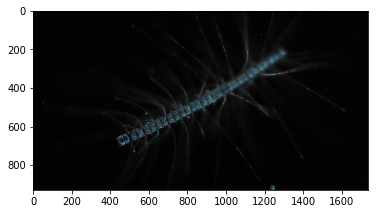

In [2]:
# get the file path of the image in the directory. here grab the diatom chain 
ptf = glob.glob(os.path.join(os.getcwd(), 'SPC*'))

# We will grab the first item in the list
img = cv2.imread(ptf[0])

# check to make sure we got the right thing
plt.imshow(img)

This region is one that we might have extracted using techniques for the previous module. Like when find the regions, we need to generate a binary mask to tell the computer what to focus on.

## Get a binary mask

To start the mask we will use a new edge detector called a Scharr filter. The Scharr filter is an operator similar to Canny that searchers for edges in the intensity image. It is well suited to finding high frequency edges.

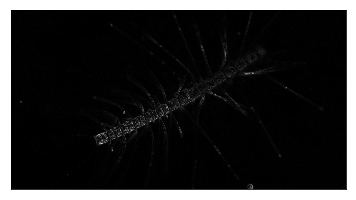

In [41]:
# make the image gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# compute the edges
edges_mag = filters.scharr(img_gray)

# see what it looks like
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(edges_mag, cmap='gray')

The Scharr filter returns gray scale values. Let's make it binary a setting a threshold that is 3 times the median value in the array. This makes our mask more apt to retain edges that using something like Otsu's method.

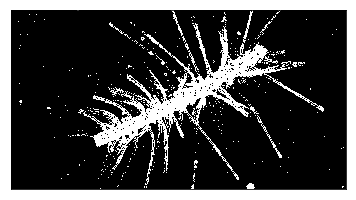

In [50]:
edges_med = np.median(edges_mag)

edges_thresh = 3*edges_med
edges = edges_mag >= edges_thresh

# see what it looks like
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(edges, cmap='gray')

That doesn't look too bad. But we want to fill in the boundary and select only the largest one for processing. To start with, we can use morphological operations to seal up some of those holes. 

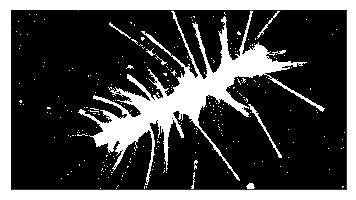

In [55]:
# these will fill in some of the holes
edges = morphology.closing(edges, morphology.square(3))
filled_edges = ndimage.binary_fill_holes(edges)

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(filled_edges, cmap='gray')

The hole filling has expanded the mask a bit. The region growing effectively got rid of the holes, but bloated the mask. Eroding, another morphological operation, will shrink it down again. 

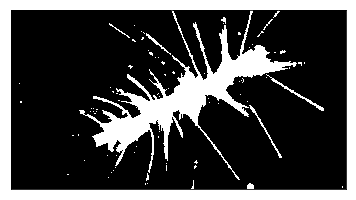

In [57]:
img_close = morphology.erosion(filled_edges, morphology.square(3))

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(img_close, cmap='gray')

It also got rid of some of the smaller noise. We can now use skimages *label* routine to find all the connected regions in the frame. 

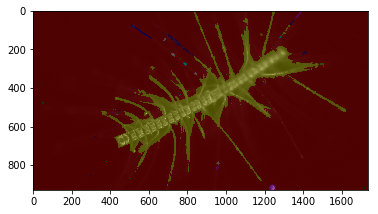

In [59]:
# pass the label routine the closed image to register connected regions.
label_img = morphology.label(img_close, neighbors=8, background=0)
lab_img_color = color.label2rgb(label_img, image=img_gray)

# plot the whole image and the subregion next to each other
plt.imshow(lab_img_color, cmap='gray')

The yellow boundardy encompasses the diatom chain and gets most of the spines. Before analyzing it, we need to select only the largest boundary in the frame. Regionprops will extract this information.

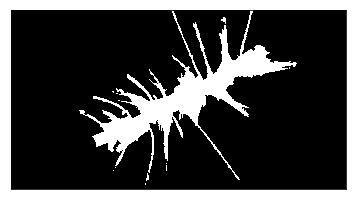

In [68]:
# use region props. But this time, have it retain all the properties it can measure
props = measure.regionprops(label_img, img_gray)
max_area = 0
max_area_ind = 0
for f in range(0,len(props)):
    if props[f].area > max_area:
        max_area = props[f].area
        max_area_ind = f

ii = max_area_ind

# now just display that area with the bounding box to make sure it got the right one.

# this selects only the pixels in the labeled image that are in the region with the biggest area
bw_mask = (label_img) == props[ii].label

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(bw_mask, cmap='gray')

[]

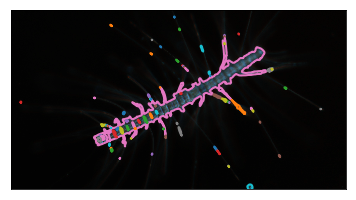

In [5]:
# get the contours. The second argument defines the value along which to
# find the contour.
contours = measure.find_contours(bw_img, 0.5)

fig, ax = plt.subplots()
ax.imshow(img)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
ax.set_xticks([])
ax.set_yticks([])

Notice that it found a lot of noise contours and objects inside the actual diatom chain we are interested in. But clearly, the largest one is organism. We can select the largest one much the same way as when we the largest regions for extraction.

[]

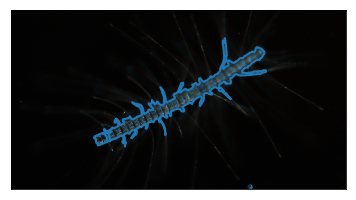

In [6]:
# set the max_contour length really low. 
# notice this is not the actual length of the boundary. We are using the 
# length of the list coordinates as a proxy.
max_length = -1
max_contour = []  # empty list for the contour
for cc in contours:
    if (len(cc) > max_length):
        max_length = len(cc)
        max_contour = cc
        
# check that grabbed the right one. 
fig, ax = plt.subplots()
ax.imshow(img)

# plot the biggest contout
ax.plot(max_contour[:, 1], max_contour[:, 0], linewidth=2)
    
ax.set_xticks([])
ax.set_yticks([])

To use this nice boundary to make a mask, we must place the list of coordinates into an array.

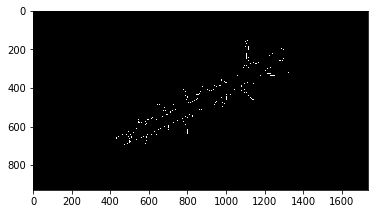

In [7]:
# create an empty array of zeros the same size as the original image
boundary = np.zeros(img_gray.shape)

# round the values of the contour to be whole numbers
yy = np.round(max_contour[:, 1])
xx = np.round(max_contour[:, 0])

# now set the pixel coordinates to of the boundary as 1
boundary[xx.astype(int), yy.astype(int)] = 1

# plot it to make sure the coordinates are right
plt.imshow(boundary, cmap='gray')

Oops! The points are not quite filled in. The plot function used above interpolated between the points. 

In [16]:
# Interpolate to 4096 point contour
interp_xx = interpolate.interp1d(range(0, max_length), max_contour[:, 0])
interp_yy = interpolate.interp1d(range(0, max_length), max_contour[:, 1])
new_space = np.linspace(0, max_length-1, 4096)
c_xx = interp_xx(new_space)
c_yy = interp_yy(new_space)

# round
xx = np.round(c_xx)
yy = np.round(c_yy)

# make integers
xx = xx.astype(np.int)
yy = yy.astype(np.int)

# dimensions
mm, nn = img_gray.shape

# place 
np.place(xx, xx >= mm, mm-1)
np.place(yy, yy >= nn, nn-1)

In [15]:
len(xx)

4096

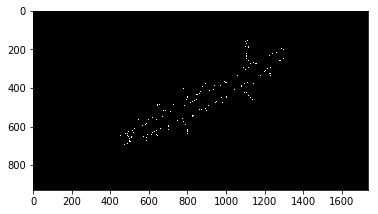

In [17]:
# create an empty array of zeros the same size as the original image
boundary = np.zeros(img_gray.shape)

# now set the pixel coordinates to of the boundary as 1
boundary[xx, yy] = 1

# plot it to make sure the coordinates are right
plt.imshow(boundary, cmap='gray')

In [18]:
fill = ndimage.binary_fill_holes(boundary)

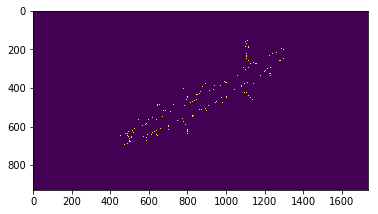

In [20]:
plt.imshow(fill)

In [14]:
    # Interpolate to 4096 point contour
    interpX = interpolate.interp1d(range(0,max_length),max_contour[:,0])
    interpY = interpolate.interp1d(range(0,max_length),max_contour[:,1])
    newS = np.linspace(0,max_length-1,4096)
    cX = interpX(newS)
    cY = interpY(newS)
    cPath = cX +1j*cY
    FdAll = np.fft.fft(cPath)
    #FdSave = np.absolute(FdAll[2:18])/np.absolute(FdAll[1])
        
    # Add to feature vector
    #X[0:16] = FdSave
        
    # Simplify the boundary
    cen = np.fft.fftshift(FdAll)
    
    # take first 10% of fourier coefficents
    cen2 = np.hstack([np.zeros(1843), cen[1843:2253], np.zeros(1843)])
    # Back project to simplified boundary
    back = np.fft.ifft(np.fft.ifftshift(cen2))
    
    xx = np.round(back.real)
    yy = np.round(back.imag)
    
    m = img_gray.shape[0]
    n = img_gray.shape[1]
    
    xx = xx.astype(np.int)
    yy = yy.astype(np.int)
    
    np.place(xx, xx >= m, m-1)
    np.place(yy, yy >= n, n-1)
    
    simp = np.zeros([m,n])
    simp[xx,yy] = 1To
    
    # Fill the simplified boundary
    fill = ndimage.binary_fill_holes(simp).astype(int)

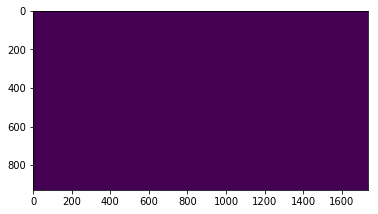

In [15]:
plt.imshow(fill)

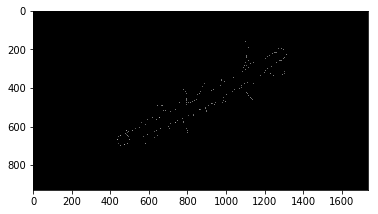

In [28]:
temp = fill * img_gray
plt.imshow(temp, cmap='gray')

In [13]:
temp = np.zeros(img_gray.shape)
cX[0]

703.5

In [43]:
edges_mag = filters.scharr(img_gray)
edges_med = np.median(edges_mag)
edges_thresh = 3*edges_med
edges = edges_mag >= edges_thresh
edges = morphology.closing(edges, morphology.square(3))
filled_edges = ndimage.binary_fill_holes(edges)
#edges = morphology.erosion(filled_edges, morphology.square(3))


In [44]:
edges_thresh

0.005199314567548143

In [46]:
test = filters.threshold_otsu(edges_mag)
test

0.02670795554330619

In [30]:
edges_mag.max()

0.2909462391100589

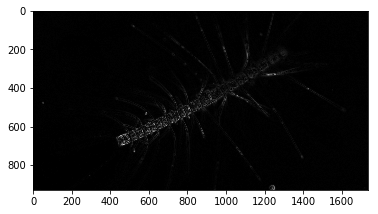

In [24]:
plt.imshow(edges_mag, cmap='gray')

In [37]:
max_length

6155

In [38]:
len(cX)

4096